In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk 
import re
from tqdm import tqdm
import pymorphy2
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
import gensim.downloader as api
import numpy as np



In [39]:
#Грузим data_set, проверяем на аномалии. Я взял dataset https://www.kaggle.com/datasets/luthfim/steam-reviews-dataset , так как в первой домашке я отзывы не выкачивал, я конечно выкачал рейтинг, но к сожалению я делал по нему сортировку и там был от положительных. А для домашки я решил что было бы все равно не плохо русский датасет=)
raw_df=pd.read_csv("steam_reviews.csv")

In [40]:
raw_df.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
0,2019-02-10,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns
1,2019-02-10,0,0,184,False,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns
2,2019-02-07,0,0,892,False,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns
3,2018-06-14,126,1086,676,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight
4,2017-06-20,85,2139,612,False,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight


In [41]:
raw_df.info(),raw_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434891 entries, 0 to 434890
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   date_posted             434891 non-null  object
 1   funny                   434891 non-null  int64 
 2   helpful                 434891 non-null  int64 
 3   hour_played             434891 non-null  int64 
 4   is_early_access_review  434891 non-null  bool  
 5   recommendation          434891 non-null  object
 6   review                  433375 non-null  object
 7   title                   434891 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 23.6+ MB


(None, (434891, 8))

In [42]:
# Данных куча, дропнем все наны и дубликаты
raw_df.drop_duplicates(subset='review', keep='first', inplace=True)
raw_df.dropna(subset=['review'], inplace=True)
raw_df.reset_index(drop=True, inplace=True)
raw_df.info(),raw_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379911 entries, 0 to 379910
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   date_posted             379911 non-null  object
 1   funny                   379911 non-null  int64 
 2   helpful                 379911 non-null  int64 
 3   hour_played             379911 non-null  int64 
 4   is_early_access_review  379911 non-null  bool  
 5   recommendation          379911 non-null  object
 6   review                  379911 non-null  object
 7   title                   379911 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 20.7+ MB


(None, (379911, 8))

Самая короткая review - 1
+
Самая длинная review - 31949
Battlegrounds&gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &gt &g

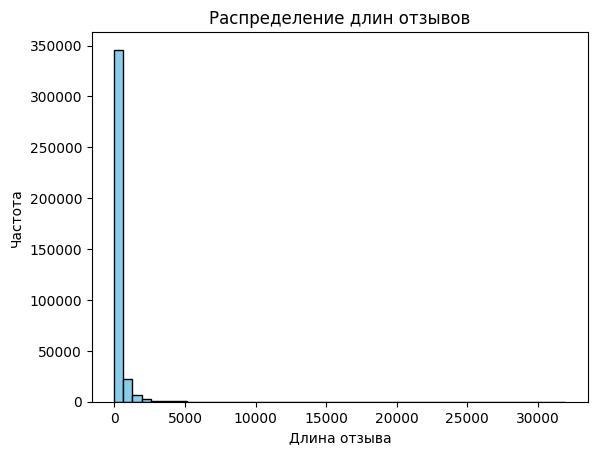

In [43]:
#глянем самые короткие и длинные отзывы, может еще что удалим... очень короткие вряд ли интересно... Очень длинные если будут выбивыться - тоже
shortest_review = raw_df.loc[raw_df['review'].str.len().idxmin()]['review']
longest_review = raw_df.loc[raw_df['review'].str.len().idxmax()]['review']

print(f"Самая короткая review - {len(shortest_review)}")
print(shortest_review)
print(f"Самая длинная review - {len(longest_review)}")
print(longest_review)
review_lengths = raw_df['review'].str.len()
plt.hist(review_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Распределение длин отзывов')
plt.xlabel('Длина отзыва')
plt.ylabel('Частота')
plt.show()

In [44]:
#походу можно снести все что больше 500 и думаю что совсем короткие отзывы тоже не показательны. В какую сторону, кто там ставит скобочку =) так что сохраним все что от 4 символов
raw_df = raw_df[(raw_df['review'].str.len() >= 4) & (raw_df['review'].str.len() <= 500)]
raw_df.reset_index(drop=True, inplace=True)
raw_df.info(),raw_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332402 entries, 0 to 332401
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   date_posted             332402 non-null  object
 1   funny                   332402 non-null  int64 
 2   helpful                 332402 non-null  int64 
 3   hour_played             332402 non-null  int64 
 4   is_early_access_review  332402 non-null  bool  
 5   recommendation          332402 non-null  object
 6   review                  332402 non-null  object
 7   title                   332402 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 18.1+ MB


(None, (332402, 8))

In [45]:
#посмотрим что там в самых коротких, может надо было сильней пилить. тот же яндекс к примеру любит побольше слов в отзывах

shortest_review = raw_df.loc[raw_df['review'].str.len().idxmin()]['review']

print(f"Самая короткая review - {len(shortest_review)}")
print(shortest_review)

Самая короткая review - 4
yes.


In [46]:
# Получим количество отзывов для каждой рекомендации
rating_counts = raw_df.groupby('recommendation').size().reset_index(name='recommendation_Count')

print("Количество отзывов для каждой рекомендации:")
print(rating_counts)

Количество отзывов для каждой рекомендации:
    recommendation  recommendation_Count
0  Not Recommended                102467
1      Recommended                229935


In [47]:
# загружаем список стоп-слов для русского
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

# примеры стоп-слов
print(len(stop_words))
print(stop_words[:10])

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vlamykin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
#запишем предобработку в виде функции
regex = re.compile(r'[А-Яа-яA-zёЁ-]+')

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text)).lower()
    except:
        return ""

word_tokenizer = nltk.WordPunctTokenizer()

In [49]:
def process_data(data):
    texts = []
    targets = []

    for item in tqdm(data):

        text_lower = words_only(item) 
        tokens     = word_tokenizer.tokenize(text_lower) 

        # удаляем пунктуацию и стоп-слова
        tokens = [word for word in tokens if (word not in stop_words and not word.isnumeric())]

        texts.append(tokens) 

    return texts

In [50]:
# запускаем нашу предобработку
y = raw_df["recommendation"].to_list()
texts = process_data(raw_df["review"])

  0%|          | 0/332402 [00:00<?, ?it/s]

100%|██████████| 332402/332402 [00:10<00:00, 31476.06it/s]


In [51]:
i=10
print(f"recommendation: {y[i]}, Tokens: {texts[i][:5]}")

recommendation: Recommended, Tokens: ['reeeeeeeee']


In [52]:
# инициализируем лемматизатор :)
morph = pymorphy2.MorphAnalyzer()

In [53]:
# применяем лемматизацию ко всем текстам
for i in tqdm(range(len(texts))):           # tqdm создает шкалу прогресса :)
    text_lemmatized = [morph.parse(x)[0].normal_form for x in texts[i]] # применяем лемматизацию для каждого слова в тексте
    texts[i] = ' '.join(text_lemmatized)                # объединяем все слова в одну строку через пробел

100%|██████████| 332402/332402 [00:53<00:00, 6202.91it/s]


In [54]:
#сохраню ка я это, если вдруг перезапущусь
with open('text_lemmatized.txt', 'w', encoding='utf-8') as file:
    for text in texts:
        file.write(text + '\n')

In [55]:
# Функция для кодирования лейблов
def label2num(y):
    if y == 'Recommended':
        return 1
    if y == 'Not Recommended':
        return -1

encoded_y = [label2num(yy) for yy in y]

In [56]:
#Разобъем на train,test... Балл не лишний=)
train_texts, test_texts, train_y, test_y = train_test_split(texts, encoded_y, test_size=0.2, random_state=42, stratify = y)

In [57]:
# Fit TF-IDF on train texts, вероятно за это 2 балла дают=)
vectorizer = TfidfVectorizer(max_features = 200, norm = None) # возмем топ 200 слов
vectorizer.fit(train_texts)

# Топ-10 слов
vectorizer.get_feature_names_out()[:10]

array(['access', 'actually', 'alot', 'already', 'also', 'always',
       'amazing', 'another', 'anyone', 'around'], dtype=object)

In [58]:
# Обучаем TF-IDF на train, а затем применяем к train и test за это вроде еще 2 балла, хотя по идеи бы после random forest бы=)... а потом еще и грид серч заделаем, вроде в том что сделать есть, но она без балов, но почему бы и нет=))
train_X = vectorizer.fit_transform(train_texts)
test_X  = vectorizer.transform(test_texts)

In [59]:
train_X.todense()[:2] # посмотрим на первые 2 строки

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         5.4543849 , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 3.16919967, 4.81522409, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0

In [60]:
# инициализируем модель
clf = RandomForestClassifier(n_estimators = 500, max_depth = 10)

# обучаем ее на тренировочных данных, еще 2 балла подоспели=)
clf = clf.fit(train_X, train_y)

# делаем предсказание для тестовых данных
pred = clf.predict(test_X)

In [61]:
print('Предсказанные рекомендации: ', pred[:10], ".....")
print('Истинные рекомендации: ', test_y[:10], ".....")

Предсказанные рекомендации:  [1 1 1 1 1 1 1 1 1 1] .....
Истинные рекомендации:  [-1, 1, 1, -1, -1, 1, -1, 1, 1, 1] .....


In [62]:
# Функция для кодирования лейблов
def num2label(y):
    if y == 1:
        return 'Recommended'
    if y == -1:
        return 'Not Recommended'
decoded_pred = [num2label(y) for y in pred]
decoded_test_y = [num2label(y) for y in test_y]
print('Предсказанные метки: ', decoded_pred[0:20], ".....")
print('Истинные метки: ', decoded_test_y [0:20], ".....")

Предсказанные метки:  ['Recommended', 'Recommended', 'Recommended', 'Recommended', 'Recommended', 'Recommended', 'Recommended', 'Recommended', 'Recommended', 'Recommended', 'Recommended', 'Recommended', 'Recommended', 'Recommended', 'Recommended', 'Recommended', 'Recommended', 'Recommended', 'Recommended', 'Not Recommended'] .....
Истинные метки:  ['Not Recommended', 'Recommended', 'Recommended', 'Not Recommended', 'Not Recommended', 'Recommended', 'Not Recommended', 'Recommended', 'Recommended', 'Recommended', 'Recommended', 'Not Recommended', 'Recommended', 'Not Recommended', 'Recommended', 'Recommended', 'Recommended', 'Recommended', 'Not Recommended', 'Not Recommended'] .....


In [63]:
print('Accuracy: ', accuracy_score(test_y, pred))
print('F1: ', f1_score(test_y, pred, average = 'macro'))

Accuracy:  0.7506806455979904
F1:  0.6004187701731558


In [64]:
for i in range(10):
    print('Истинный лейбл:',test_y[-i])
    print('Предсказанный лейбл:',pred[-i])
    print('Текст новости: ', train_texts[-i][:500]+'...')
    print('\n')

Истинный лейбл: -1
Предсказанный лейбл: 1
Текст новости:  great game game play atmosphere tasks immersing great degree freedom play style viable customize play style wish wide array weapon armor intersting comunity lots achivements extended gameplay continous new content recommended...


Истинный лейбл: 1
Предсказанный лейбл: 1
Текст новости:  ...


Истинный лейбл: 1
Предсказанный лейбл: 1
Текст новости:  hello spoderman n tuday im gunna reveew dis game spawn dis game nuded get hert guy weth rock hert gaem...


Истинный лейбл: 1
Предсказанный лейбл: 1
Текст новости:  game keren...


Истинный лейбл: 1
Предсказанный лейбл: 1
Текст новости:  good game need carry though...


Истинный лейбл: 1
Предсказанный лейбл: 1
Текст новости:  hi rockstar games jackass https www change org p rockstar games save openiv...


Истинный лейбл: 1
Предсказанный лейбл: -1
Текст новости:  naked men...


Истинный лейбл: -1
Предсказанный лейбл: 1
Текст новости:  product received free red code quest account sir...

In [65]:
param_grid = {
        'n_estimators': range(400, 601, 100),
        'max_depth': range(5,16,5)
}
cls=RandomForestClassifier()

grid_search = GridSearchCV(cls, param_grid, cv=3, scoring='f1', verbose=1)
grid_search.fit(train_X, train_y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(5, 16, 5),
                         'n_estimators': range(400, 601, 100)},
             scoring='f1', verbose=1)

In [66]:
print("Best CV score: {:.3f}, best CV n_estimators: {}, best CV max_depth: {}".format(
    grid_search.best_score_, grid_search.best_estimator_.n_estimators, grid_search.best_estimator_.max_depth
))

test_predictions = grid_search.best_estimator_.predict(test_X)
print("Resulting test f1 score: {:.3f}".format(f1_score(test_predictions, test_y)))
print('Resulting test accuracy: ', accuracy_score(test_predictions, test_y))

Best CV score: 0.854, best CV n_estimators: 500, best CV max_depth: 15
Resulting test f1 score: 0.855
Resulting test accuracy:  0.7713933304252343


In [67]:
wv = api.load('word2vec-google-news-300')


In [68]:
# получаем еше 3 балла
# https://www.kaggle.com/code/utkarsh293/tf-idf-weighted-word2vec-model-using-xgboost/notebook почерпнул информацию отсюда и напряг GPT3.5 для получения ответа как же получить word2vec из tf-idf
# Получение tf-idf весов
tfidf_weights = train_X.toarray()

# Векторизация текста с весами tf-idf и word2vec 
def vectorize_with_tfidf_and_word2vec(text, tfidf_weights, word2vec_model):
    word_vectors = []
    words = text.split()
    for word in words:
        if word in word2vec_model:
            # Получение вектора word2vec для слова
            w2v_vector = word2vec_model[word]
            # Получение tf-idf веса для слова
            tfidf_weight = tfidf_weights[words.index(word)]
            # Умножение вектора word2vec на tf-idf вес
            weighted_w2v_vector = w2v_vector * tfidf_weight
            word_vectors.append(weighted_w2v_vector)
    
    if word_vectors:
        # Усреднение векторов слов для получения вектора предложения
        sentence_vector = np.mean(word_vectors, axis=0)
        return sentence_vector
    else:
        # Если нет слов из word2vec модели в тексте, вернуть нулевой вектор
        return np.zeros_like(word2vec_model['word'])

# Применение функции к каждому тексту в train_texts
train_vectors = [vectorize_with_tfidf_and_word2vec(text, tfidf_weights[i], wv) for i, text in enumerate(train_texts)]

# Применение функции к каждому тексту в test_texts
test_vectors = [vectorize_with_tfidf_and_word2vec(text, tfidf_weights[i], wv) for i, text in enumerate(test_texts)]

In [69]:
# Получаем еще 2 балла, итого 10 =)))
# инициализируем модель
clf = RandomForestClassifier(n_estimators = 500, max_depth = 10)

# обучаем ее на тренировочных данных, еще 2 балла подоспели=)
clf = clf.fit(train_vectors, train_y)

# делаем предсказание для тестовых данных
pred = clf.predict(test_vectors)

In [70]:
print('Accuracy: ', accuracy_score(test_y, pred))
print('F1: ', f1_score(test_y, pred, average = 'macro'))

Accuracy:  0.6945743896752455
F1:  0.4305945384721149


In [71]:
#ну и просто ради интереса запускаю на ночь grid-search аналогичный тому, что был в прошлый раз
param_grid = {
        'n_estimators': range(400, 601, 100),
        'max_depth': range(5,16,5)
}
cls=RandomForestClassifier()

grid_search = GridSearchCV(cls, param_grid, cv=3, scoring='f1', verbose=1)
grid_search.fit(train_vectors, train_y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(5, 16, 5),
                         'n_estimators': range(400, 601, 100)},
             scoring='f1', verbose=1)

In [72]:
print("Best CV score: {:.3f}, best CV n_estimators: {}, best CV max_depth: {}".format(
    grid_search.best_score_, grid_search.best_estimator_.n_estimators, grid_search.best_estimator_.max_depth
))

test_predictions = grid_search.best_estimator_.predict(test_vectors)
print("Resulting test f1 score: {:.3f}".format(f1_score(test_predictions, test_y)))
print('Resulting test accuracy: ', accuracy_score(test_predictions, test_y))

Best CV score: 0.818, best CV n_estimators: 400, best CV max_depth: 10
Resulting test f1 score: 0.818
Resulting test accuracy:  0.6944239707585625
